In [ ]:
cd drive/MyDrive/Colab\ Notebooks/cells

/content/drive/MyDrive/Colab Notebooks/cells


In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import geo
import utils

# set device and load models
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gm, gm_opt, gm_loss_hist = utils.load_model("gmvae_20230221_014308.pt", "gmvae", {"input_dim": 2766, "latent_dim": 2, "num_clusters": 5}, dev)
vae, vae_opt, vae_loss_hist = utils.load_model("vae_20230221_014308.pt", "vae", {"input_dim": 2766, "latent_dim": 2}, dev)

In [ ]:
from geo import compute_length_of_curve, get_Riemannian_metric

# compute the length of two crossing curves in latent space
curve1 = torch.tensor([[-2, -2], [-1.5, -1.5], [-1, -1], [-0.5, -0.5], [0, 0], [0.5, 0.5], [1, 1], [1.5, 1.5], [2, 2]]).to(dev)
curve2 = torch.tensor([[-2, 2], ## compute the geodesic between two points in latent space
[-1.5, 1.5], [-1, 1], [-0.5, 0.5], [0, 0], [0.5, -0.5], [1, -1], [1.5, -1.5], [2, -2]]).to(dev)

vae_len1 = compute_length_of_curve(curve1, vae.decode, get_Riemannian_metric).item()
vae_len2 = compute_length_of_curve(curve2, vae.decode, get_Riemannian_metric).item()

gm_len1 = compute_length_of_curve(curve1, gm.decode, get_Riemannian_metric).item()
gm_len2 = compute_length_of_curve(curve2, gm.decode, get_Riemannian_metric).item()

print("  VAE: %f, %f" % (vae_len1, vae_len2))
print("GMVAE: %f, %f" % (gm_len1, gm_len2))

  VAE: 336.583252, 456.003662
GMVAE: 162.408325, 130.855530


In [ ]:
# load the data
test_loader = utils.create_dataloader("celegan", 8192, shuffle=False)
test = test_loader.dataset.data.to(dev)
print("Test data shape: %s" % str(test.shape))

# compute the latent representations 
gm.eval()
vae.eval()

gm_latent = gm.reparameterize(*gm.encode(test), temperature=0.5)[0].detach().cpu().numpy()
vae_latent = vae.encode(test)[0].detach().cpu().numpy()
print("Latent representations shape: %s" % str(gm_latent.shape))

torch.Size([86024, 2766])
Test data shape: torch.Size([86024, 2766])
Latent representations shape: (86024, 2)


In [ ]:
# helpers for picking interesting latent points 
def get_index(latent, threshold=500):
    return np.where(np.abs(latent[:, 1]) > threshold)[0]

def get_i_over(latent, threshold=500):
    return np.where(latent[:, 1] > threshold)[0]

def get_i_under(latent, threshold=-500):
    return np.where(latent[:, 1] < threshold)[0]

# get the latent points
gm_subset_over = gm_latent[get_i_over(gm_latent, 500)]
gm_subset_under = gm_latent[get_i_under(gm_latent, -500)]

vae_subset_over = vae_latent[get_i_over(vae_latent, 3.5)]
vae_subset_under = vae_latent[get_i_under(vae_latent, -15)]

gm_p1, gm_p2 = gm_subset_over[0], gm_subset_under[0]
vae_p1, vae_p2 = vae_subset_over[0], vae_subset_under[0]

# cast to torch and unsqueeze
gm_p1, gm_p2 = torch.tensor(gm_p1).unsqueeze(0), torch.tensor(gm_p2).unsqueeze(0)
vae_p1, vae_p2 = torch.tensor(vae_p1).unsqueeze(0), torch.tensor(vae_p2).unsqueeze(0)

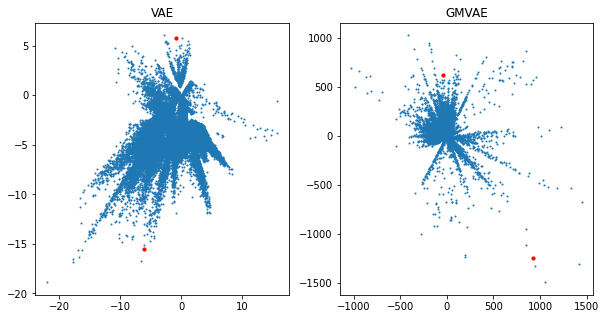

In [ ]:
# plot the latent space and chosen points 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(vae_latent[:, 0], vae_latent[:, 1], s=1)
plt.scatter(vae_p1[0,0], vae_p1[0,1], c="red", s=10)
plt.scatter(vae_p2[0,0], vae_p2[0,1], c="red", s=10)
plt.title("VAE")
plt.subplot(1, 2, 2)
plt.scatter(gm_latent[:, 0], gm_latent[:, 1], s=1)
plt.scatter(gm_p1[0,0], gm_p1[0,1], c="red", s=10)
plt.scatter(gm_p2[0,0], gm_p2[0,1], c="red", s=10)
plt.title("GMVAE")
plt.show()

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated successfully.
         Current function value: 148.886078
         Iterations: 9
         Function evaluations: 4574
   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: array(148.88607788)
 message: 'Optimization terminated successfully.'
    nfev: 4574
     nit: 9
  status: 0
 success: True
       x: array([ -1.3508767 ,   2.42568729,  -5.33341607,  -1.35005863,
        -6.01128522,  -5.95695716,  -5.12022738, -10.0171718 ,
        -5.63430825, -12.80995177])


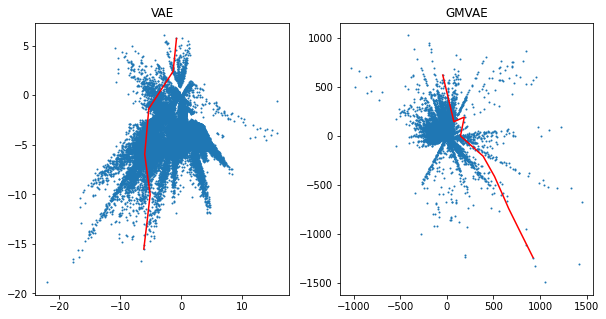

In [37]:
# ---------------------------------------------------------
# compute the geodesic between two points in latent space - 
# ---------------------------------------------------------

# lambda function which takes x and returns torch.tensor(x): 
# t = lambda x: torch.tensor(x)

# # get the latent space coordinates of the two points
# i1, i2 = 0, 1500
# p1_vae = t(vae_latent[i1:i1+1])
# p2_vae = t(vae_latent[i2:i2+1])

# p1_gm = t(gm_latent[i1:i1+1])
# p2_gm = t(gm_latent[i2:i2+1])

vae_p1, vae_p2, gm_p1, gm_p2 = vae_p1.to(dev), vae_p2.to(dev), gm_p1.to(dev), gm_p2.to(dev)

# compute the geodesic
curve_vae = geo.compute_geodesic(vae_p1, vae_p2, vae.decode, get_Riemannian_metric, 7, dev).to("cpu")
# curve_gm = geo.compute_geodesic(gm_p1, gm_p2, gm.decode, get_Riemannian_metric, 10, dev).to("cpu")

# plot the geodesic
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(vae_latent[:, 0], vae_latent[:, 1], s=1)
plt.plot(curve_vae[:, 0], curve_vae[:, 1], c="r")
plt.title("VAE")
plt.subplot(1, 2, 2)
plt.scatter(gm_latent[:, 0], gm_latent[:, 1], s=1)
plt.plot(curve_gm[:, 0], curve_gm[:, 1], c="r")
plt.title("GMVAE")
plt.show()

In [ ]:
len1 = geo.compute_length_of_curve(curve_gm.to(dev), gm.decode, get_Riemannian_metric)

gm_linear = geo.compute_linear(gm_p1, gm_p2, 15, dev)
len2 = geo.compute_length_of_curve(gm_linear.to(dev), gm.decode, get_Riemannian_metric)

len1, len2

(tensor(8125.5771, device='cuda:0'), tensor(11150.1855, device='cuda:0'))

In [ ]:
asd
# do a kernel PCA on the latent space of the GMVAE
from sklearn.decomposition import KernelPCA, IncrementalPCA

# add the curve to the latent space
gm_latent2 = np.concatenate((gm_latent, curve_gm), axis=0)

# do the kernel PCA
# pca = KernelPCA(n_components=2, kernel="cosine") #kernel="rbf", gamma=0.1) # RUNS OUT OF MEMORY
pca = IncrementalPCA(n_components=2)
gm_reduced = pca.fit_transform(gm_latent2)

# plot the latent space and the projection
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gm_latent2[:, 0], gm_latent2[:, 1], s=1)
plt.title("GMVAE latent space")
plt.subplot(1, 2, 2)
plt.scatter(gm_reduced[:, 0], gm_reduced[:, 1], s=1)
curve_indices = np.arange(gm_latent.shape[0], gm_latent2.shape[0])
plt.scatter(gm_reduced[curve_indices, 0], gm_reduced[curve_indices, 1], c="red", s=1)
plt.title("PCA projection")
plt.show()


In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=72ff7051e2873543421d6c56839c96358ab3070f13293e7a0af135bdf86679d5
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=3277759576095a66878499a6f9b41b7a71e9976ba308f1233495e9e2af5f2651
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
# Do the same with UMAP projection
import umap

# do the UMAP projection
umap_proj = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric="cosine")
gm_reduced_umap = umap_proj.fit_transform(gm_latent2)

# plot the latent space and the projection
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gm_latent2[:, 0], gm_latent2[:, 1], s=1)
plt.title("GMVAE")
plt.subplot(1, 2, 2)
# plot the projection but color the curve differently
plt.scatter(gm_reduced_umap[:, 0], gm_reduced_umap[:, 1], s=1)

# get the indices of the curve
curve_indices = np.arange(gm_latent.shape[0], gm_latent2.shape[0])
plt.scatter(gm_reduced_umap[curve_indices, 0], gm_reduced_umap[curve_indices, 1], c="red", s=1)
plt.title("UMAP projection")
plt.show()
